# Batch Normalization and Dropout — Explained Simply

**Who this is for:** Anyone who knows basic neural networks and wants to understand why training often fails — and how BN and Dropout fix it.

**What we cover:**
- What problem each technique solves
- How they work (with simple math)
- Side-by-side model comparison with visualizations
- Practical rules for when to use each

---

## 1. The Problem They Solve

When training a deep neural network, two things commonly go wrong:

**Problem 1 — Unstable training (Internal Covariate Shift)**

As weights update in one layer, the distribution of inputs to the next layer keeps shifting. The network wastes time re-adapting every step. This makes training slow and fragile.

**Batch Normalization** fixes this by normalizing each layer's inputs to have mean 0 and std 1 at every step.

---

**Problem 2 — Overfitting**

The network memorizes training data instead of learning general patterns. It scores well on train data but poorly on new data.

**Dropout** fixes this by randomly switching off neurons during training, forcing the network to learn robust, non-co-dependent features.

---

## 2. How Batch Normalization Works

For each mini-batch, BN does:

**Step 1 — Normalize the batch:**
$$\hat{x} = \frac{x - \mu_{batch}}{\sqrt{\sigma^2_{batch} + \epsilon}}$$

Subtract mean, divide by std. Output now has mean ≈ 0, std ≈ 1.

**Step 2 — Scale and shift (learnable):**
$$y = \gamma \hat{x} + \beta$$

$\gamma$ and $\beta$ are learned — the network can undo the normalization if needed.

**At inference:** uses running mean/std accumulated during training.

**Benefits:** faster convergence, less sensitive to learning rate, mild regularization.

---

## 3. How Dropout Works

During training, each neuron is switched off with probability `p`:

$$\tilde{h}_j = \text{Bernoulli}(1-p) \cdot h_j$$

Active neurons are scaled by $\frac{1}{1-p}$ to keep output magnitudes consistent.

**At inference:** Dropout is disabled — all neurons active. Just call `model.eval()` in PyTorch.

**Why it works:** Each training step uses a different random sub-network. The model can't rely on any single neuron — it learns redundant, general representations.

---

## 4. Correct Layer Order

```
Linear  →  BatchNorm  →  ReLU  →  Dropout  →  (next layer)
```

- BN goes **before** the activation (normalizes raw linear output)
- Dropout goes **after** the activation (drops activated values)
- Never use Dropout on the final output layer

---

## 5. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

plt.style.use('seaborn-v0_8-whitegrid')
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch {torch.__version__} | Device: {DEVICE}')

PyTorch 2.10.0+cpu | Device: cpu


## 6. Synthetic E-Commerce Dataset

We generate 6,000 synthetic customer records. Task: predict whether a customer will churn (binary classification).

| Feature | Meaning |
|---|---|
| tenure_months | How long they have been a customer |
| annual_spend | Total yearly spend (USD) |
| num_orders | Orders placed in the last 12 months |
| return_rate | Fraction of orders returned |
| support_tickets | Number of support contacts |
| days_since_last_order | Recency of last purchase |
| loyalty_tier | 0=Bronze, 1=Silver, 2=Gold |
| newsletter_open_rate | Email engagement rate |

In [2]:
def generate_data(n=6000, seed=42):
    rng = np.random.default_rng(seed)
    loyalty = rng.choice([0, 1, 2], n, p=[0.5, 0.35, 0.15])
    tenure  = rng.integers(1, 120, n)
    spend   = (200 + loyalty*300 + rng.normal(0,150,n) + tenure*2.5).clip(50, 5000)
    orders  = (spend/80 + rng.normal(0,2,n)).clip(1, 60).astype(int)
    ret     = (0.3 - loyalty*0.05 + rng.normal(0,0.08,n)).clip(0, 0.9)
    tickets = rng.poisson(2 - loyalty*0.4, n).clip(0, 15)
    recency = (rng.exponential(30,n) + tickets*5).clip(1, 365).astype(int)
    openr   = (0.25 + loyalty*0.1 + rng.normal(0,0.1,n)).clip(0, 1)
    score   = (-0.01*tenure + 0.008*recency + 1.2*ret + 0.15*tickets
               - 0.8*openr - 0.4*loyalty + rng.normal(0,0.5,n))
    churn   = (rng.random(n) < 1/(1+np.exp(-score))).astype(int)
    return pd.DataFrame({
        'tenure_months': tenure, 'annual_spend': spend.round(2),
        'num_orders': orders, 'return_rate': ret.round(4),
        'support_tickets': tickets, 'days_since_last_order': recency,
        'loyalty_tier': loyalty, 'newsletter_open_rate': openr.round(4),
        'churned': churn
    })

df = generate_data()
print(f'Shape: {df.shape} | Churn rate: {df.churned.mean():.2%}')
df.head()

Shape: (6000, 9) | Churn rate: 44.93%


,tenure_months,annual_spend,num_orders,return_rate,support_tickets,days_since_last_order,loyalty_tier,newsletter_open_rate,churned
0,61,417.58,4,0.2175,4,107,1,0.3036,0
1,55,565.48,8,0.4573,0,48,0,0.3171,1
2,9,974.43,14,0.2220,2,49,2,0.3667,1
3,15,590.09,7,0.2032,1,10,1,0.3641,0
4,71,402.41,4,0.2195,0,8,0,0.2552,0


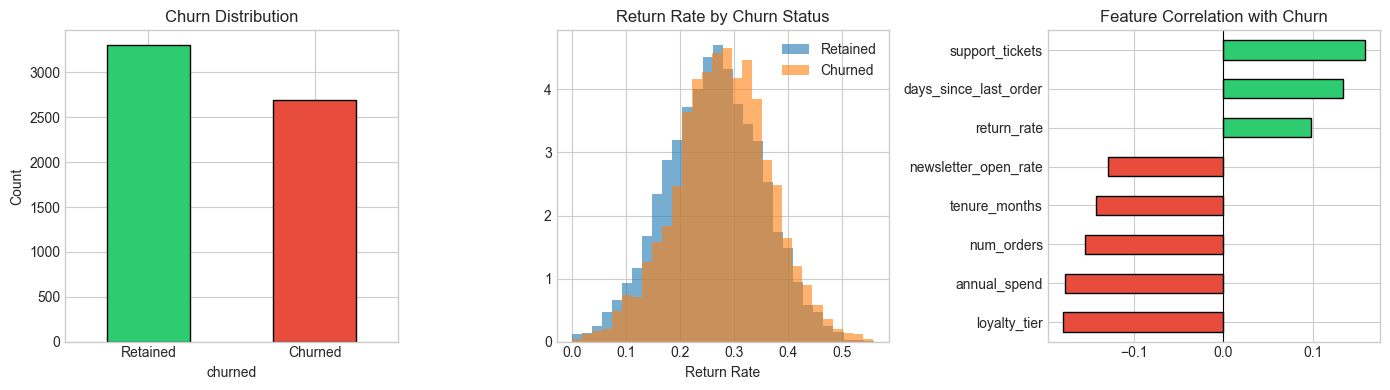

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Churn balance
df['churned'].value_counts().plot(kind='bar', ax=axes[0],
    color=['#2ecc71','#e74c3c'], edgecolor='black')
axes[0].set_xticklabels(['Retained', 'Churned'], rotation=0)
axes[0].set_title('Churn Distribution')
axes[0].set_ylabel('Count')

# Return rate distribution by churn
for label, grp in df.groupby('churned'):
    axes[1].hist(grp['return_rate'], bins=30, alpha=0.6, density=True,
                 label='Churned' if label else 'Retained')
axes[1].set_title('Return Rate by Churn Status')
axes[1].set_xlabel('Return Rate')
axes[1].legend()

# Feature correlations with churn
corr = df.drop('churned', axis=1).corrwith(df['churned']).sort_values()
colors = ['#e74c3c' if v < 0 else '#2ecc71' for v in corr]
corr.plot(kind='barh', ax=axes[2], color=colors, edgecolor='black')
axes[2].axvline(0, color='black', lw=0.8)
axes[2].set_title('Feature Correlation with Churn')

plt.tight_layout()
plt.show()

## 7. Data Preparation

In [4]:
FEATURES = [c for c in df.columns if c != 'churned']
X = df[FEATURES].values.astype(np.float32)
y = df['churned'].values.astype(np.float32)

X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)
X_val, X_te, y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=SEED)

scaler = StandardScaler()
X_tr  = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_val)
X_te  = scaler.transform(X_te)

def make_loader(X, y, bs=256, shuffle=True):
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
    return DataLoader(ds, batch_size=bs, shuffle=shuffle)

train_loader = make_loader(X_tr, y_tr)
val_loader   = make_loader(X_val, y_val, shuffle=False)
test_loader  = make_loader(X_te, y_te, shuffle=False)
IN = X_tr.shape[1]

print(f'Features: {IN} | Train: {len(X_tr)} | Val: {len(X_val)} | Test: {len(X_te)}')

Features: 8 | Train: 4200 | Val: 900 | Test: 900


## 8. Model Architecture

One configurable class — toggle BN and Dropout on/off for fair comparison.

```
Input(8) → Linear(128) → [BN] → ReLU → [Dropout]
         → Linear(64)  → [BN] → ReLU → [Dropout]
         → Linear(32)  → [BN] → ReLU → [Dropout]
         → Linear(1)   → Output
```

In [5]:
class ChurnNet(nn.Module):
    def __init__(self, in_features, hidden=[128, 64, 32],
                 use_bn=False, dropout_p=0.0):
        super().__init__()
        layers, prev = [], in_features
        for h in hidden:
            layers.append(nn.Linear(prev, h))
            if use_bn:
                layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            if dropout_p > 0:
                layers.append(nn.Dropout(p=dropout_p))
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(1)

print(ChurnNet(IN, use_bn=True, dropout_p=0.3))

ChurnNet(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)


## 9. Training and Evaluation Utilities

In [6]:
def train_model(model, train_loader, val_loader, epochs=50, lr=1e-3):
    model = model.to(DEVICE)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    hist = {'train_loss':[], 'val_loss':[], 'train_auc':[], 'val_auc':[]}

    for _ in range(epochs):
        model.train()
        tl, tp, tlb = [], [], []
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            tl.append(loss.item())
            tp.extend(torch.sigmoid(out).detach().cpu().numpy())
            tlb.extend(yb.cpu().numpy())
        scheduler.step()

        model.eval()
        vl, vp, vlb = [], [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                out = model(xb)
                vl.append(criterion(out, yb).item())
                vp.extend(torch.sigmoid(out).cpu().numpy())
                vlb.extend(yb.cpu().numpy())

        hist['train_loss'].append(np.mean(tl))
        hist['val_loss'].append(np.mean(vl))
        hist['train_auc'].append(roc_auc_score(tlb, tp))
        hist['val_auc'].append(roc_auc_score(vlb, vp))

    return model, hist


def evaluate(model, loader):
    model.eval()
    probs, labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            out = model(xb.to(DEVICE))
            probs.extend(torch.sigmoid(out).cpu().numpy())
            labels.extend(yb.numpy())
    return roc_auc_score(labels, probs)

print('Utilities ready.')

Utilities ready.


## 10. Train Four Models

Same architecture, same data, only BN and Dropout differ.

| Model | Batch Norm | Dropout |
|---|---|---|
| Baseline | No | No |
| BatchNorm | Yes | No |
| Dropout | No | Yes (p=0.3) |
| BN + Dropout | Yes | Yes (p=0.3) |

In [7]:
configs = {
    'Baseline':    dict(use_bn=False, dropout_p=0.0),
    'BatchNorm':   dict(use_bn=True,  dropout_p=0.0),
    'Dropout':     dict(use_bn=False, dropout_p=0.3),
    'BN+Dropout':  dict(use_bn=True,  dropout_p=0.3),
}
COLORS = {
    'Baseline':   '#e74c3c',
    'BatchNorm':  '#3498db',
    'Dropout':    '#2ecc71',
    'BN+Dropout': '#9b59b6'
}

trained, histories = {}, {}
for name, cfg in configs.items():
    print(f'Training {name}...')
    m, h = train_model(ChurnNet(IN, **cfg), train_loader, val_loader, epochs=50)
    trained[name], histories[name] = m, h
print('Done.')

Training Baseline...
Training BatchNorm...
Training Dropout...
Training BN+Dropout...
Done.


## 11. Training Curves

Solid lines = training, dashed lines = validation.

**What to look for:**
- A large gap between solid and dashed means overfitting
- BatchNorm converges faster (loss drops quicker)
- Dropout closes the gap between train and val

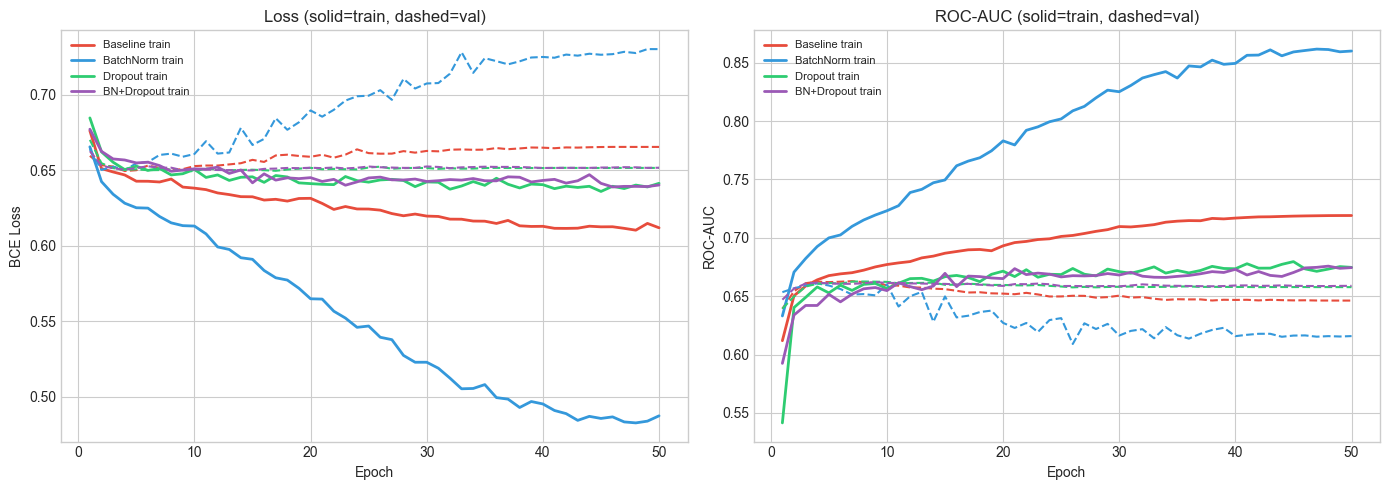

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ep = range(1, 51)

for name, h in histories.items():
    c = COLORS[name]
    axes[0].plot(ep, h['train_loss'], color=c, lw=2,   label=f'{name} train')
    axes[0].plot(ep, h['val_loss'],   color=c, lw=1.5, linestyle='--')
    axes[1].plot(ep, h['train_auc'], color=c, lw=2,   label=f'{name} train')
    axes[1].plot(ep, h['val_auc'],   color=c, lw=1.5, linestyle='--')

axes[0].set_title('Loss (solid=train, dashed=val)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('BCE Loss')
axes[0].legend(fontsize=8)

axes[1].set_title('ROC-AUC (solid=train, dashed=val)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('ROC-AUC')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

## 12. Test Performance and Overfitting Comparison

In [9]:
rows = []
for name, m in trained.items():
    h = histories[name]
    rows.append({
        'Model': name,
        'Test AUC': evaluate(m, test_loader),
        'Best Val AUC': max(h['val_auc']),
        'Overfit Gap': round(h['train_auc'][-1] - h['val_auc'][-1], 4)
    })

result_df = pd.DataFrame(rows).sort_values('Test AUC', ascending=False).reset_index(drop=True)
print(result_df.to_string(index=False, float_format='{:.4f}'.format))

     Model  Test AUC  Best Val AUC  Overfit Gap
   Dropout    0.6515        0.6626       0.0169
BN+Dropout    0.6503        0.6622       0.0156
  Baseline    0.6399        0.6629       0.0729
 BatchNorm    0.5916        0.6610       0.2442


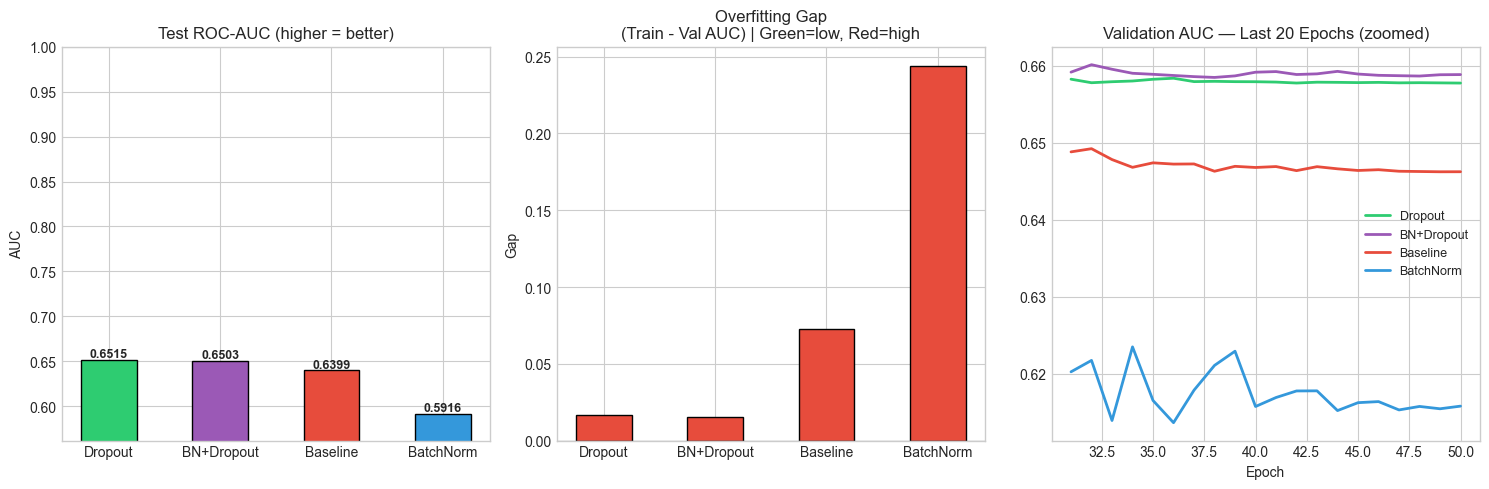

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
names  = result_df['Model'].tolist()
colors = [COLORS[n] for n in names]

# Test AUC
bars = axes[0].bar(names, result_df['Test AUC'], color=colors, edgecolor='black', width=0.5)
axes[0].set_ylim(result_df['Test AUC'].min() - 0.03, 1.0)
axes[0].set_title('Test ROC-AUC (higher = better)')
axes[0].set_ylabel('AUC')
for bar, val in zip(bars, result_df['Test AUC']):
    axes[0].text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.003,
                 f'{val:.4f}', ha='center', fontsize=9, fontweight='bold')

# Overfitting gap
gap_colors = ['#2ecc71' if g < 0.01 else '#e74c3c' for g in result_df['Overfit Gap']]
axes[1].bar(names, result_df['Overfit Gap'], color=gap_colors, edgecolor='black', width=0.5)
axes[1].axhline(0, color='black', lw=0.8)
axes[1].set_title('Overfitting Gap\n(Train - Val AUC) | Green=low, Red=high')
axes[1].set_ylabel('Gap')

# Last 20 epochs zoomed
for name in names:
    axes[2].plot(range(31, 51), histories[name]['val_auc'][30:],
                 color=COLORS[name], lw=2, label=name)
axes[2].set_title('Validation AUC — Last 20 Epochs (zoomed)')
axes[2].set_xlabel('Epoch')
axes[2].legend(fontsize=9)

plt.tight_layout()
plt.show()

## 13. Visualizing Internal Covariate Shift

This is **why Batch Normalization exists**.

Without BN, activations in deep layers drift to extreme ranges — the network struggles to learn. With BN, they stay tightly centered around 0 at every layer, making gradient flow smooth and consistent.

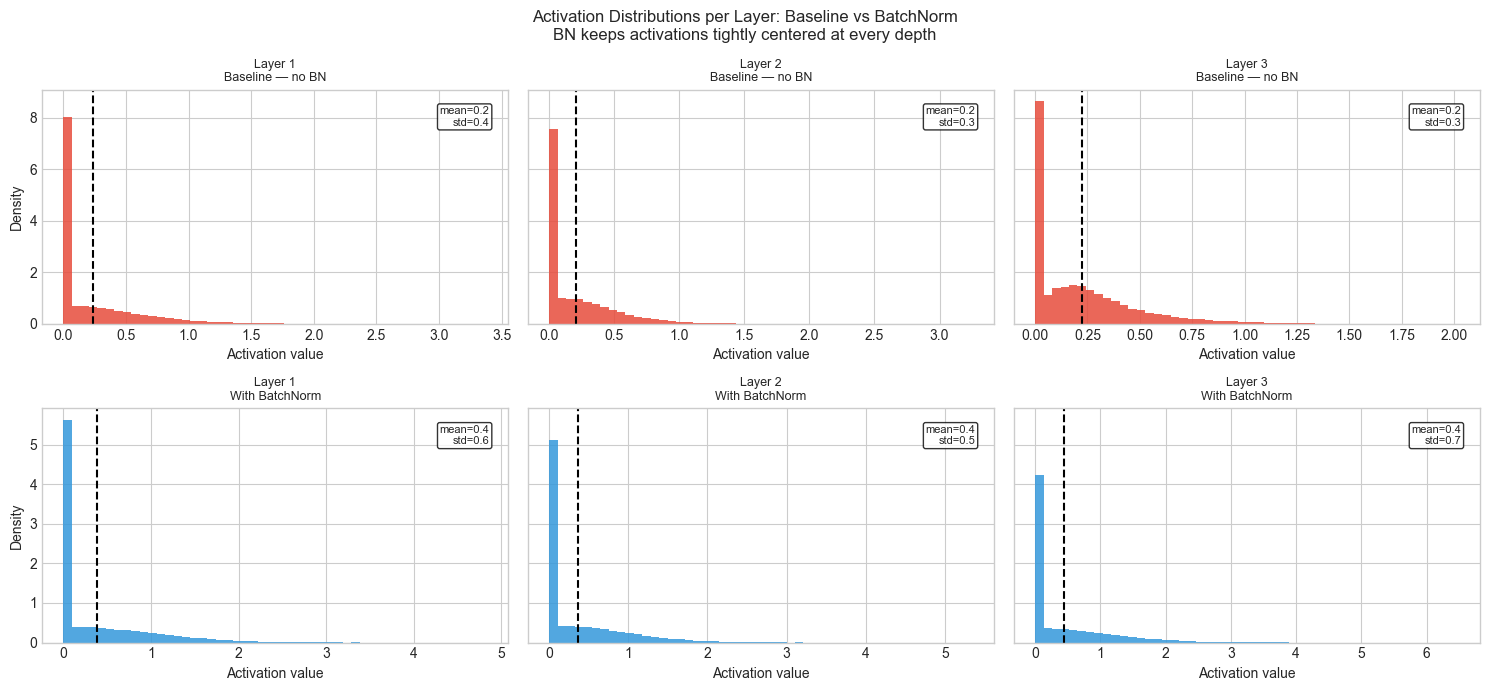

In [11]:
def get_activations(model, loader, max_batches=4):
    store, hooks, count = {}, [], [0]

    def make_hook(idx):
        def hook(m, inp, out):
            key = f'Layer {idx}'
            store.setdefault(key, []).append(out.detach().cpu().numpy().flatten())
        return hook

    for layer in model.net:
        if isinstance(layer, nn.ReLU):
            count[0] += 1
            hooks.append(layer.register_forward_hook(make_hook(count[0])))

    model.eval()
    with torch.no_grad():
        for i, (xb, _) in enumerate(loader):
            if i >= max_batches: break
            model(xb.to(DEVICE))

    for h in hooks: h.remove()
    return {k: np.concatenate(v) for k, v in store.items()}


acts_base = get_activations(trained['Baseline'], train_loader)
acts_bn   = get_activations(trained['BatchNorm'], train_loader)
layers    = sorted(acts_base.keys())

fig, axes = plt.subplots(2, len(layers), figsize=(5*len(layers), 7), sharey='row')

for col, layer in enumerate(layers):
    for row, (acts, label, color) in enumerate([
        (acts_base, 'Baseline — no BN', '#e74c3c'),
        (acts_bn,   'With BatchNorm',   '#3498db')
    ]):
        ax = axes[row][col]
        data = acts[layer]
        ax.hist(data, bins=50, color=color, alpha=0.85, density=True)
        mu, sd = data.mean(), data.std()
        ax.axvline(mu, color='black', lw=1.5, ls='--')
        ax.set_title(f'{layer}\n{label}', fontsize=9)
        ax.set_xlabel('Activation value')
        if col == 0: ax.set_ylabel('Density')
        ax.text(0.96, 0.93, f'mean={mu:.1f}\nstd={sd:.1f}',
                transform=ax.transAxes, ha='right', va='top', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.8))

plt.suptitle('Activation Distributions per Layer: Baseline vs BatchNorm\n'
             'BN keeps activations tightly centered at every depth', fontsize=12)
plt.tight_layout()
plt.show()

## 14. Visualizing Dropout — What Gets Dropped

Each row is one training forward pass. Green = neuron active. Red = neuron dropped.

Notice each pass uses a different random sub-network — this is what forces robust learning.

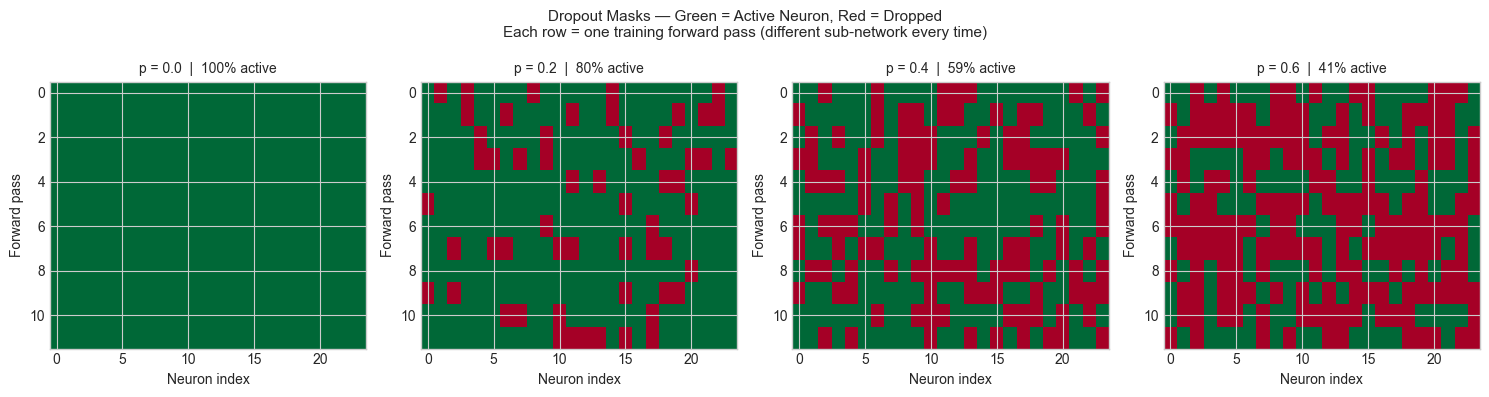

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
rng = np.random.default_rng(0)
N_NEURONS, N_PASSES = 24, 12

for ax, p in zip(axes, [0.0, 0.2, 0.4, 0.6]):
    mask = rng.random((N_PASSES, N_NEURONS)) > p
    ax.imshow(mask.astype(float), cmap='RdYlGn', vmin=0, vmax=1, aspect='auto')
    ax.set_title(f'p = {p}  |  {mask.mean()*100:.0f}% active', fontsize=10)
    ax.set_xlabel('Neuron index')
    ax.set_ylabel('Forward pass')

plt.suptitle('Dropout Masks — Green = Active Neuron, Red = Dropped\n'
             'Each row = one training forward pass (different sub-network every time)', fontsize=11)
plt.tight_layout()
plt.show()

## 15. Dropout Rate Sweep — Finding the Sweet Spot

Too little dropout = overfitting. Too much = underfitting (network can't learn). There's an optimal middle.

p=0.0 | test AUC=0.6520 | overfit gap=0.0440
p=0.1 | test AUC=0.6534 | overfit gap=0.0290
p=0.2 | test AUC=0.6519 | overfit gap=0.0234
p=0.3 | test AUC=0.6548 | overfit gap=0.0096
p=0.4 | test AUC=0.6514 | overfit gap=0.0075
p=0.5 | test AUC=0.6516 | overfit gap=-0.0056


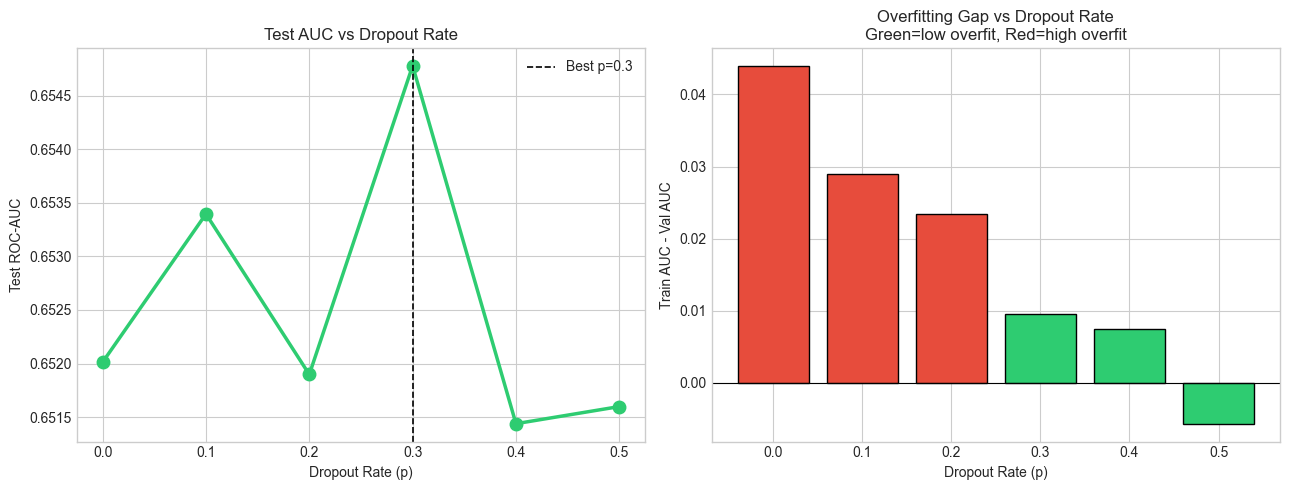

In [13]:
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
dr_rows = []

for p in dropout_rates:
    m, h = train_model(ChurnNet(IN, use_bn=False, dropout_p=p),
                       train_loader, val_loader, epochs=40)
    dr_rows.append({
        'p': p,
        'test_auc': evaluate(m, test_loader),
        'overfit':  h['train_auc'][-1] - h['val_auc'][-1]
    })
    print(f'p={p} | test AUC={dr_rows[-1]["test_auc"]:.4f} | overfit gap={dr_rows[-1]["overfit"]:.4f}')

dr_df = pd.DataFrame(dr_rows)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

best_p = dr_df.loc[dr_df['test_auc'].idxmax(), 'p']
axes[0].plot(dr_df['p'], dr_df['test_auc'], 'o-', color='#2ecc71', lw=2.5, markersize=9)
axes[0].axvline(best_p, color='black', ls='--', lw=1.2, label=f'Best p={best_p}')
axes[0].set_xlabel('Dropout Rate (p)')
axes[0].set_ylabel('Test ROC-AUC')
axes[0].set_title(f'Test AUC vs Dropout Rate')
axes[0].legend()

gap_colors = ['#2ecc71' if g < 0.01 else '#e74c3c' for g in dr_df['overfit']]
axes[1].bar(dr_df['p'].astype(str), dr_df['overfit'],
            color=gap_colors, edgecolor='black')
axes[1].axhline(0, color='black', lw=0.8)
axes[1].set_xlabel('Dropout Rate (p)')
axes[1].set_ylabel('Train AUC - Val AUC')
axes[1].set_title('Overfitting Gap vs Dropout Rate\nGreen=low overfit, Red=high overfit')

plt.tight_layout()
plt.show()

## 16. Learning Rate Robustness — A Key BN Benefit

Without BN, a high learning rate causes training to diverge (AUC drops). With BN, the model stays stable across a much wider range. This means you can train faster with less tuning.

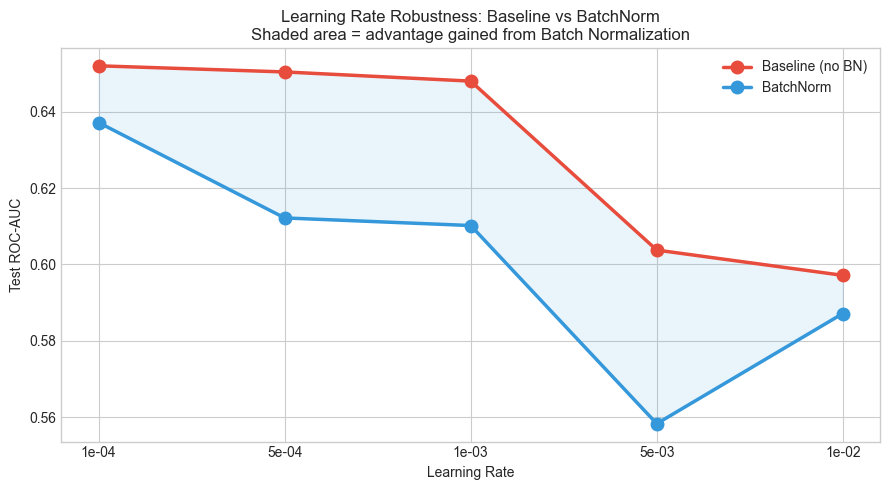

In [14]:
lrs = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
lr_base, lr_bn = [], []

for lr in lrs:
    m1, _ = train_model(ChurnNet(IN, use_bn=False), train_loader, val_loader, epochs=40, lr=lr)
    lr_base.append(evaluate(m1, test_loader))
    m2, _ = train_model(ChurnNet(IN, use_bn=True),  train_loader, val_loader, epochs=40, lr=lr)
    lr_bn.append(evaluate(m2, test_loader))

lr_labels = [f'{v:.0e}' for v in lrs]

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(lr_labels, lr_base, 'o-', color='#e74c3c', lw=2.5, markersize=9, label='Baseline (no BN)')
ax.plot(lr_labels, lr_bn,   'o-', color='#3498db', lw=2.5, markersize=9, label='BatchNorm')
ax.fill_between(lr_labels, lr_base, lr_bn, alpha=0.1, color='#3498db')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Test ROC-AUC')
ax.set_title('Learning Rate Robustness: Baseline vs BatchNorm\n'
             'Shaded area = advantage gained from Batch Normalization')
ax.legend()
plt.tight_layout()
plt.show()

## 17. Practical Summary

### Batch Normalization — Quick Reference

| | |
|---|---|
| **What it fixes** | Unstable training, slow convergence |
| **How** | Normalizes activations to mean=0, std=1 per mini-batch |
| **Placement** | `Linear → BN → ReLU` |
| **At inference** | Uses running stats from training (auto via `model.eval()`) |
| **Watch out** | Small batch sizes (under 16) — statistics get noisy |

### Dropout — Quick Reference

| | |
|---|---|
| **What it fixes** | Overfitting |
| **How** | Randomly zeros neurons, forces redundant representations |
| **Placement** | `Linear → BN → ReLU → Dropout` |
| **Typical rate** | 0.2–0.4 for hidden layers |
| **At inference** | Automatically disabled via `model.eval()` |
| **Watch out** | Too high (> 0.5) + small data = underfitting |

### Decision Guide

| Situation | What to do |
|---|---|
| Training is slow or unstable | Add Batch Normalization |
| Train accuracy >> Val accuracy | Add or increase Dropout |
| Both train and val accuracy are low | Reduce dropout, use larger model |
| Batch size under 16 | Use Layer Normalization instead of BN |
| Transformers or RNNs | Use Layer Normalization |
| General deep MLP | BN + Dropout (p=0.2–0.3) is a solid default |